[View in Colaboratory](https://colab.research.google.com/github/maxmatical/fast.ai/blob/master/fast_ai_cifar_v3.ipynb)

# Training a model from scratch on CIFAR10

# Guides 

loading data: https://hackernoon.com/training-an-image-classifier-from-scratch-in-15-minutes-3c140f5fa1af

https://github.com/fastai/fastai/blob/master/courses/dl1/lesson7-cifar10.ipynb

http://forums.fast.ai/t/training-a-model-from-scratch-cifar-10/7897

creating train/test directories http://forums.fast.ai/t/not-a-directory-error-in-cifar10-exercise/13401/6

https://www.kaggle.com/hortonhearsafoo/fast-ai-lesson-7-cifar10

In [1]:
# script for installing fastai and required libraries
# note: using pytoch 0.3.0, may have to change later
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
!pip install Pillow==4.0.0
!pip install image
%matplotlib inline
!pip install fastai
!pip install pathlib
from fastai.imports import *

  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.2.0
    Uninstalling Pillow-5.2.0:
      Successfully uninstalled Pillow-5.2.0


In [2]:
# check for CUDA
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)

#print('Device:', torch.device('cuda:0'))


0.3.0.post4
True
Torch 0.3.0.post4 CUDA 8.0.61


In [3]:
# PIL workaround
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


# loading cifar10

In [4]:
!cd data && wget http://files.fast.ai/data/cifar10.tgz && tar -xf cifar10.tgz


Redirecting output to ‘wget-log’.


In [0]:
from fastai.conv_learner import *
PATH = "data/cifar10/"
os.makedirs(PATH,exist_ok=True)

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))


def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

bs=256

# visualizing data

In [0]:
data = get_data(32,4)


In [0]:
x,y=next(iter(data.trn_dl))


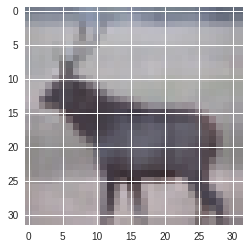

In [14]:
plt.imshow(data.trn_ds.denorm(x)[0]);


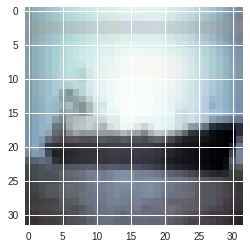

In [15]:
plt.imshow(data.trn_ds.denorm(x)[1]);


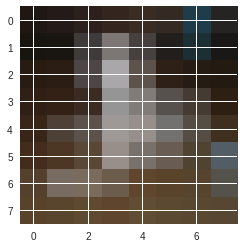

In [32]:
data_plot = get_data(16,4)
x,y=next(iter(data.trn_dl))
plt.imshow(data.trn_ds.denorm(x)[0]);


# loading a model

using Squeeze-and-excitation network

In [0]:
# loading SENEt model (no weights)
from fastai.models.cifar10.senet import SENet18

In [0]:
m = SENet18()
basic_model = BasicModel(m.cuda(), name = 'SENet_18')

In [0]:
# 8x8 model
data = get_data(8,bs*4)

In [0]:
# creating model
model = ConvLearner(data, basic_model)
model.unfreeze()

In [0]:
# setting learning rate
lr=1e-2; wd=5e-4

In [23]:
model.lr_find()

 94%|█████████▍| 46/49 [01:59<00:07,  2.43s/it, loss=26]  

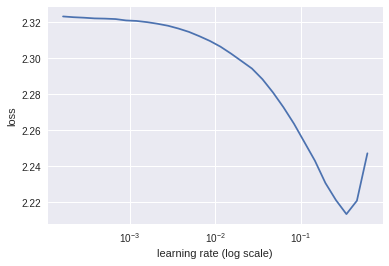

In [26]:
model.sched.plot()

In [0]:
# good learning point looks like 10^(-1)
# resetting lr
lr = 1; wd=5e-4

In [28]:
# initial model fitting for 1 epoch

model.fit(lr, 1)

epoch      trn_loss   val_loss   accuracy   
    0      1.659172   1.509288   0.4495    


[array([1.50929]), 0.4494999999046326]

In [29]:
# fitting with learning rate shecule + weight decay

%time model.fit(lr, 1, cycle_len=10, use_clr=(32,10), wds = wd) # cyclical learning rate Slanted triangular LR for 1 cycle (10 epochs)

epoch      trn_loss   val_loss   accuracy   
    0      1.383855   1.338592   0.5144    
    1      1.328296   1.285363   0.5356    
    2      1.251561   1.202572   0.5754    
    3      1.174426   1.163003   0.5818    
    4      1.111753   1.131124   0.6026    
    5      1.055039   1.09512    0.6127    
    6      0.997333   1.029362   0.6379    
    7      0.939852   0.999154   0.6502    
    8      0.893495   0.970932   0.658     
    9      0.84387    0.950225   0.6612    
CPU times: user 20min 41s, sys: 3min 48s, total: 24min 30s
Wall time: 21min 5s


[array([0.95023]), 0.6611999994277954]

In [0]:
model.save('8x8')

note: no need for discriminative learning rate since we're training a model from scatch

next, 16x16 (slowly increasing size of the images)


In [0]:
# loading 8x8 model
model.load('8x8')

In [0]:
model.set_data(get_data(16, bs*2)) # setting data to be 16x16

In [48]:
# initial model fitting for 1 epoch
lr = 1e-3; wd = 5e-4
model.fit(lr, 1)

epoch      trn_loss   val_loss   accuracy   
    0      1.629073   1.591031   0.4312    


[array([1.59103]), 0.43119999980926516]

In [49]:
model.lr_find()

 96%|█████████▌| 94/98 [00:29<00:00,  4.82it/s, loss=6.71]

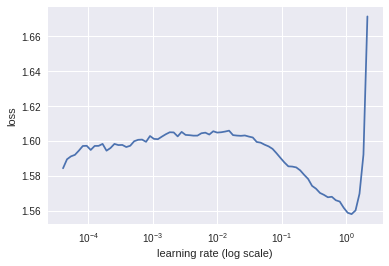

In [50]:
model.sched.plot()

In [0]:
# good learning rate seems to be 1

lr = 1e-1; wd = 5e-4

In [0]:
# unfreeze layers
model.unfreeze()

In [53]:
# fitting with learning rate shecule + weight decay

%time model.fit(lr, 1, cycle_len=10, use_clr=(32,10), wds = wd) # cyclical learning rate Slanted triangular LR for 1 cycle (10 epochs)

epoch      trn_loss   val_loss   accuracy   
    0      1.093537   1.450854   0.5488    
    1      0.912342   0.889786   0.6855    
    2      0.776193   0.852273   0.7071    
    3      0.691592   0.779262   0.729     
    4      0.609054   0.660306   0.7725    
    5      0.548398   0.601666   0.7963    
    6      0.492956   0.585824   0.7978    
    7      0.451015   0.531155   0.8188    
    8      0.400806   0.526904   0.82      
    9      0.360455   0.469349   0.8385    
CPU times: user 23min 7s, sys: 5min 34s, total: 28min 42s
Wall time: 25min 12s


[array([0.46935]), 0.8384999995231628]

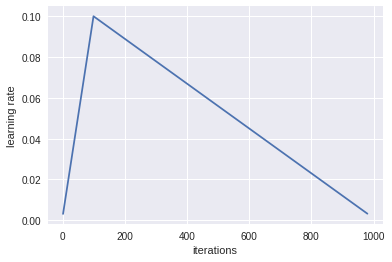

In [54]:
# plotting lr
model.sched.plot_lr()

In [0]:
model.save('16x16')

# 24x24

In [0]:
model.load('16x16')

In [0]:
model.set_data(get_data(24, bs)) # setting data to be 24x24

In [58]:
# initial model fitting for 1 epoch
lr = 1e-3; wd = 5e-4
model.fit(lr, 1, wds = wd)

epoch      trn_loss   val_loss   accuracy   
    0      0.557456   0.577941   0.7961    


[array([0.57794]), 0.7961]

In [59]:
model.lr_find()

epoch      trn_loss   val_loss   accuracy   
    0      0.885827   5.27983    0.6578    


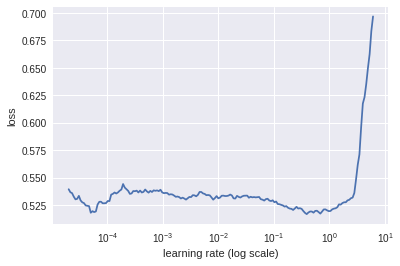

In [60]:
model.sched.plot()

In [0]:
# setting lr
lr = 1e-3; wd = 5e-4


In [0]:
# unfreeze layers
model.unfreeze()

In [63]:
# fitting with learning rate shecule + weight decay

%time model.fit(lr, 1, cycle_len=10, use_clr=(32,10), wds = wd) # cyclical learning rate Slanted triangular LR for 1 cycle (10 epochs)

epoch      trn_loss   val_loss   accuracy   
    0      0.439487   0.463022   0.8444    
    1      0.390024   0.433137   0.8538    
    2      0.364733   0.419024   0.8593    
    3      0.358304   0.408075   0.863     
    4      0.349204   0.404113   0.8644    
    5      0.344725   0.399029   0.8672    
    6      0.341672   0.396722   0.867     
    7      0.34304    0.395214   0.868     
    8      0.330678   0.395499   0.8681    
    9      0.328527   0.393164   0.8685    
CPU times: user 25min 12s, sys: 5min 45s, total: 30min 58s
Wall time: 26min 58s


[array([0.39316]), 0.8685]

In [0]:
model.save('24x24')

# 32x32

In [0]:
model.load('24x24')

In [0]:
model.set_data(get_data(32,bs))

In [69]:
model.fit(1e-2, 1, wds=wd)


epoch      trn_loss   val_loss   accuracy   
    0      0.426127   0.449932   0.8452    


[array([0.44993]), 0.8452]

In [70]:
model.lr_find()

epoch      trn_loss   val_loss   accuracy   
    0      1.120099   5.381885   0.7062    


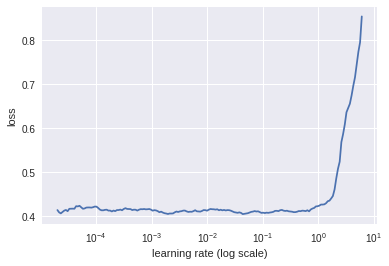

In [71]:
model.sched.plot()

In [0]:
# setting lr
lr = 1e-3; wd = 5e-4

In [0]:
# unfreeze layers
model.unfreeze()

In [74]:
# fitting with learning rate shecule + weight decay

%time model.fit(lr, 1, cycle_len=10, use_clr=(32,10), wds = wd) # cyclical learning rate Slanted triangular LR for 1 cycle (10 epochs)

epoch      trn_loss   val_loss   accuracy   
    0      0.40082    0.424974   0.8534    
    1      0.372928   0.400127   0.8626    
    2      0.358578   0.386297   0.8687    
    3      0.344321   0.374989   0.8723    
    4      0.328596   0.367654   0.8748    
    5      0.323031   0.363049   0.8777    
    6      0.316136   0.362387   0.877     
    7      0.316504   0.35746    0.8786    
    8      0.312162   0.356453   0.879     
    9      0.309152   0.356333   0.8777    
CPU times: user 38min 31s, sys: 9min 15s, total: 47min 46s
Wall time: 43min 40s


[array([0.35633]), 0.8777]

In [0]:
# fitting with learning rate shecule + weight decay

%time model.fit(1e-2, 1, cycle_len=20, use_clr=(32,10), wds = wd) # cyclical learning rate Slanted triangular LR for 1 cycle (20 epochs)

In [78]:
log_preds,y = model.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.8851

In [0]:
model.save('32x32')